# Neural Network

# Отчет по лабораторной работе №5

Подготовили Соколова Светлана и Шилов Вячеслав

In [61]:
import numpy as np
import pandas as pd
import time

import glob, os
import PIL.Image as Img
from IPython.display import Image
import matplotlib.pyplot as plt

from tensorflow.python.framework import ops
import tensorflow as tf 

from sklearn import svm
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import confusion_matrix

#data import
train = pd.read_csv("train.csv", header=None)
test = pd.read_csv("test.csv", header=None)

7


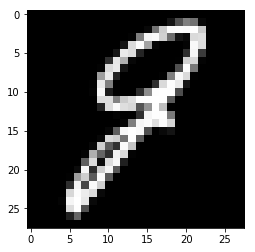

In [3]:
train = np.asarray(train)
test = np.asarray(test)
first_pic = train[8]
pic_label, pic = first_pic[0], first_pic[1:]
print(pic_label)
plt.imshow(pic.reshape((28, 28)).T, cmap='gray')
plt.show()

x_train = train[:, 1:]
x_test = test[:, 1:]

y_train_clf = train[:, 0]
y_test_clf = test[:, 0]

y_train = np.zeros((train.shape[0], 26))
for i in range(train.shape[0]):
    y_train[i, int(train[i, 0]) - 1] = 1

y_test = np.zeros((test.shape[0], 26))
for i in range(test.shape[0]):
    y_test[i, int(test[i, 0]) - 1] = 1

## 1 Создать модель нейронной сети, которая предсказывает букву по картинке

Модель обучать на данных из train.csv, качество модели проверять на данных из файла test.csv. Для построения модели желательно использовать библиотеки tensorflow и keras.

Параметры подбирали исходя из описания в документации. Batch и learning rate подбирали исходя из тестов.
НАИЛУЧШАЯ МОДЕЛЬ: с 3-мя слоями 

Learning rate =0.0001  --- 3 layers


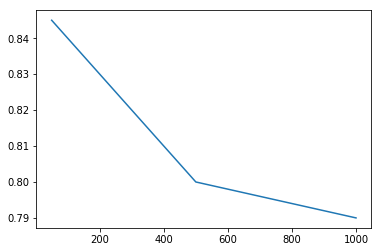

In [98]:
x=[1000, 500, 200, 100, 50]
y = [0.79, 0.8, 0.83, 0.84, 0.845]
print("Learning rate =0.0001  --- 3 layers")
plt.plot(x,y)


Learning rate =0.0005  --- 3 layers


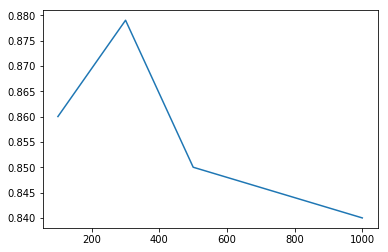

In [99]:
x=[1000, 500, 300, 100]
y = [0.84, 0.85, 0.879, 0.86]
print("Learning rate =0.0005  --- 3 layers")
plt.plot(x,y)


Можем объяснить это так: чем мельче кусок данных, на котором мы обучаем модель, тем лучше она обучается. Но важно не переобучится, поэтому  learning rate =0.0005

В итоге мы решили взять batch size = 400 и learning rate =0.0005

### 2 СКРЫТЫХ СЛОЯ

In [58]:
N, M = x_train.shape 
O = 784 
P = 256 
T = 26 
batch_size = 400
learning_rate = 0.0005 
training_epochs = 10 

ops.reset_default_graph()

inp = tf.placeholder(shape=(None, M), dtype=tf.float32) 
out = tf.placeholder(shape=(None, T), dtype=tf.float32)

weights1 = tf.Variable(tf.truncated_normal([M, O], stddev=np.sqrt(1/M))) 
bias1 = tf.Variable(tf.ones([O])/O) 
layer1 = tf.nn.relu(tf.matmul(inp, weights1) + bias1) 

weights2 = tf.Variable(tf.truncated_normal([O, P], stddev=np.sqrt(1/O))) 
bias2 = tf.Variable(tf.ones([P])/P) 
layer2 = tf.nn.relu(tf.matmul(layer1, weights2) + bias2) 

weights_output = tf.Variable(tf.truncated_normal([P,T], stddev=np.sqrt(1/P)))
bias_output = tf.Variable(tf.ones([T])/T) 
evidence=tf.matmul(layer2,  weights_output)+bias_output #y'
output = tf.nn.softmax(evidence) # - y

cross_entropy=tf.nn.softmax_cross_entropy_with_logits_v2(logits=evidence, labels=out)
cross_entropy=tf.reduce_mean(cross_entropy)

train_step=tf.train.RMSPropOptimizer(learning_rate).minimize(cross_entropy) 


correct_prediction=tf.equal(tf.argmax(output, 1), tf.argmax(out, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

tf.summary.scalar("Cost", cross_entropy)
tf.summary.scalar("Accuracy", accuracy)
summary_op=tf.summary.merge_all()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for epoch in range(training_epochs): 
        print("Epoch:", epoch + 1)
        batch_count= int(N/batch_size)
        for i in range(batch_count):
            start, finish = batch_size*i, batch_size*(i+1)
            batch_x, batch_y = x_train[start: finish, :], y_train[start: finish, :]
            d = {inp: batch_x, out: batch_y}
            _, summary=sess.run([train_step, summary_op], feed_dict=d )
        print("Accuracy: ", accuracy.eval(feed_dict={inp: x_test, out: y_test}))  

Epoch: 1
Accuracy:  0.69915384
Epoch: 2
Accuracy:  0.79846156
Epoch: 3
Accuracy:  0.8140769
Epoch: 4
Accuracy:  0.8399231
Epoch: 5
Accuracy:  0.8540769
Epoch: 6
Accuracy:  0.85615385
Epoch: 7
Accuracy:  0.8647692
Epoch: 8
Accuracy:  0.86684614
Epoch: 9
Accuracy:  0.8598462
Epoch: 10
Accuracy:  0.86946154


### 3 СКРЫТЫХ СЛОЯ 

In [59]:
N, M = x_train.shape 
O = 784 
P1 = 512 
P2 = 512
T = 26 
batch_size = 300
learning_rate = 0.0005 
training_epochs = 10 

ops.reset_default_graph()

inp = tf.placeholder(shape=(None, M), dtype=tf.float32) 
out = tf.placeholder(shape=(None, T), dtype=tf.float32)

weights1 = tf.Variable(tf.truncated_normal([M, O], stddev=np.sqrt(1/M)))
bias1 = tf.Variable(tf.ones([O])/O) 
layer1 = tf.nn.relu(tf.matmul(inp, weights1) + bias1)

weights2 = tf.Variable(tf.truncated_normal([O, P1], stddev=np.sqrt(1/O)))
bias2 = tf.Variable(tf.ones([P1])/P1) 
layer2 = tf.nn.relu(tf.matmul(layer1, weights2) + bias2)

weights3 = tf.Variable(tf.truncated_normal([P1, P2], stddev=np.sqrt(1/P1)))
bias3 = tf.Variable(tf.ones([P2])/P2)
layer3 = tf.nn.relu(tf.matmul(layer2, weights3) + bias3)

weights_output = tf.Variable(tf.truncated_normal([P2,T], stddev=np.sqrt(1/P2))) 
bias_output = tf.Variable(tf.ones([T])/T) 
evidence=tf.matmul(layer3,  weights_output)+bias_output
output = tf.nn.softmax(evidence) 

cross_entropy=tf.nn.softmax_cross_entropy_with_logits_v2(logits=evidence, labels=out)
cross_entropy=tf.reduce_mean(cross_entropy)

train_step=tf.train.RMSPropOptimizer(learning_rate).minimize(cross_entropy)

correct_prediction=tf.equal(tf.argmax(output, 1), tf.argmax(out, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

tf.summary.scalar("Cost", cross_entropy)
tf.summary.scalar("Accuracy", accuracy)
summary_op=tf.summary.merge_all()

start = time.time()
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for epoch in range(training_epochs):
        print("Epoch:", epoch + 1)
        batch_count= int(N/batch_size)
        for i in range(batch_count):
            start, finish = batch_size*i, batch_size*(i+1)
            batch_x, batch_y = x_train[start: finish, :], y_train[start: finish, :]
            d = {inp: batch_x, out: batch_y}
            _, summary=sess.run([train_step, summary_op], feed_dict=d )
        print("Accuracy: ", accuracy.eval(feed_dict={inp: x_test, out: y_test})) 
end = time.time()      
print('Time:', (end - start))

Epoch: 1
Accuracy:  0.75176924
Epoch: 2
Accuracy:  0.82530767
Epoch: 3
Accuracy:  0.84261537
Epoch: 4
Accuracy:  0.8493846
Epoch: 5
Accuracy:  0.85523075
Epoch: 6
Accuracy:  0.85953844
Epoch: 7
Accuracy:  0.86784613
Epoch: 8
Accuracy:  0.8706923
Epoch: 9
Accuracy:  0.86023074
Epoch: 10
Accuracy:  0.87961537
Time: 1545528997.789005


## 2 Матрица смежности результатов предсказаний модели на тестовых данных

Мы составили матрицу смежности и провели небольшой анализ. Ниже самой матрицы выводится информация о том: [сколько раз, какая буква, с какой перепутана]

По матрице смежности плохо идентифицируется буквы (маленькое число на диагонали):
  
     7-ая буква алфавита - G часто путается с Q или B
     
     9-ая буква алфавита - I часто путается с L
   
     12-ая буква алфавита - L часто путается с I
   
     17-ая буква алфавита - Q часто путается с G
     (общая закономерность ошибок объясняется тем, что каждая пара букв строится из набора практически одних и тех же паттернов)
     
После чего отображаются некоторое примеры ошибок: выписывается буква которую определила наша модель, затем отрисовывается само изображение.

Epoch: 1
Accuracy:  0.7593077
Epoch: 2
Accuracy:  0.829
Epoch: 3
Accuracy:  0.846
Epoch: 4
Accuracy:  0.85446155
Epoch: 5
Accuracy:  0.86415386
Epoch: 6
Accuracy:  0.8686923
Epoch: 7
Accuracy:  0.87153846
Epoch: 8
Accuracy:  0.86815387
Epoch: 9
Accuracy:  0.87223077
Epoch: 10
Accuracy:  0.87684613
Confusion matrix:  [[439   3   5   2  10   3  10   3   0   0   0   0   2   3   5   3   9   1
    1   1   0   0   0   0   0]
 [  7 455   0   2   4   0   4   6   0   1   1   3   2   1   2   3   0   1
    2   0   0   0   0   1   1]
 [  2   0 455   0  31   0   1   0   0   0   2   3   0   0   3   1   0   1
    0   1   0   0   0   0   0]
 [ 11   8   1 441   0   0   2   3   2   5   1   3   1   1   8   9   1   0
    0   0   1   0   1   1   0]
 [  2   0   8   0 478   0   1   0   1   0   2   0   0   0   0   2   0   1
    1   2   1   0   0   0   0]
 [  1   0   0   0   3 441   1   0   1   0   0   1   0   2   0  37   1   1
    1   9   0   0   0   0   1]
 [ 23   9   2   1   4   4 360   0   1   5   0   0   

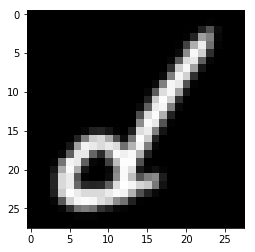

d


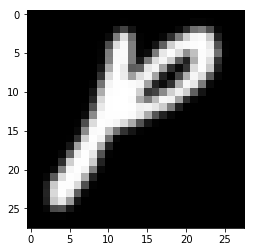

p


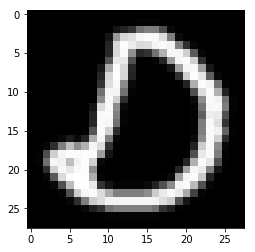

d


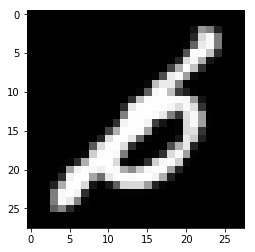

b


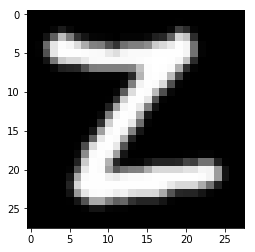

z


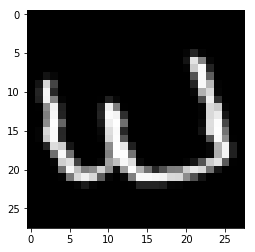

w


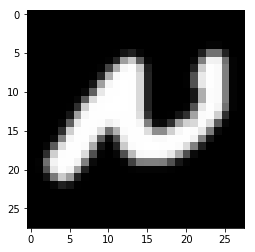

n


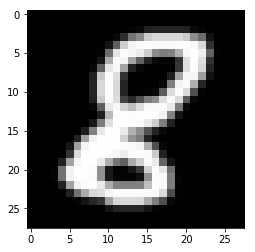

r


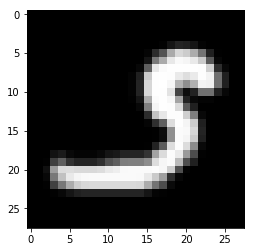

s


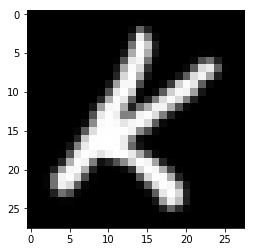

In [80]:
N, M = x_train.shape 
O = 784 
P1 = 512 
P2 = 512
T = 26 
batch_size = 300
learning_rate = 0.0005 
training_epochs = 10 

ops.reset_default_graph()

inp = tf.placeholder(shape=(None, M), dtype=tf.float32) 
out = tf.placeholder(shape=(None, T), dtype=tf.float32)

weights1 = tf.Variable(tf.truncated_normal([M, O], stddev=np.sqrt(1/M)))
bias1 = tf.Variable(tf.ones([O])/O) 
layer1 = tf.nn.relu(tf.matmul(inp, weights1) + bias1)

weights2 = tf.Variable(tf.truncated_normal([O, P1], stddev=np.sqrt(1/O)))
bias2 = tf.Variable(tf.ones([P1])/P1) 
layer2 = tf.nn.relu(tf.matmul(layer1, weights2) + bias2)

weights3 = tf.Variable(tf.truncated_normal([P1, P2], stddev=np.sqrt(1/P1)))
bias3 = tf.Variable(tf.ones([P2])/P2)
layer3 = tf.nn.relu(tf.matmul(layer2, weights3) + bias3)

weights_output = tf.Variable(tf.truncated_normal([P2,T], stddev=np.sqrt(1/P2))) 
bias_output = tf.Variable(tf.ones([T])/T) 
evidence=tf.matmul(layer3,  weights_output)+bias_output
output = tf.nn.softmax(evidence) 

cross_entropy=tf.nn.softmax_cross_entropy_with_logits_v2(logits=evidence, labels=out)
cross_entropy=tf.reduce_mean(cross_entropy)

train_step=tf.train.RMSPropOptimizer(learning_rate).minimize(cross_entropy)

correct_prediction=tf.equal(tf.argmax(output, 1), tf.argmax(out, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

tf.summary.scalar("Cost", cross_entropy)
tf.summary.scalar("Accuracy", accuracy)
summary_op=tf.summary.merge_all()


with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for epoch in range(training_epochs):
        print("Epoch:", epoch + 1)
        batch_count= int(N/batch_size)
        for i in range(batch_count):
            start, finish = batch_size*i, batch_size*(i+1)
            batch_x, batch_y = x_train[start: finish, :], y_train[start: finish, :]
            d = {inp: batch_x, out: batch_y}
            _, summary=sess.run([train_step, summary_op], feed_dict=d ) 
        print("Accuracy: ", accuracy.eval(feed_dict={inp: x_test, out: y_test}))
        
        if(epoch == 9):
            new_y_true= y_test_clf
            new_y_pred= sess.run(tf.argmax(output, 1), feed_dict={inp: x_test})
            cm = confusion_matrix(new_y_true, new_y_pred)[1:27, 0:25]
            print('Confusion matrix: ', cm)
            lttrs = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
            top_errors = []
            for i in range(cm.shape[0]):
                for j in range(cm.shape[1]):
                    if (cm[i, j] > 10 and i != j):
                        top_errors.append([cm[i, j], lttrs[i], lttrs[j]])
            top_errors.sort()
            print('Top errors: ', top_errors)
        
            num_pics = 10
            for i in range(len(new_y_true)):
                if (new_y_true[i] != new_y_pred[i] and num_pics > 0):
                    print(lttrs[new_y_pred[i-1]])
                    plt.imshow(x_test[i].reshape((28, 28)).T, cmap='gray')
                    plt.show()
                    num_pics-=1

## Пример из жизни. Сравним нашу модель с государственной нейронкой для проверки ЕГЭ

Так как наша модель достаточно часто путала буквы G и Q, то мы решили проверить и посмотреть как наша модель справится на практике с задачей из реальной жизни.

2016 год, Света сдает ЕГЭ по английскому. Задача идентификации букв из бланков ответа ЕГЭ. 

Как видно из ниже представленных фрагментах РЕАЛЬНЫХ ответов, на РЕАЛЬНОМ ЕГЭ автоматическая проверка перепутала буквы G и Q (ответ №19). 

Проверим, как наша модель идентифицирует букву. 

Для идентификации мы взяли модель без скрытых слоёв, так как она работает быстрее, и проверим точность предсказания в 5-ти эпохах. 

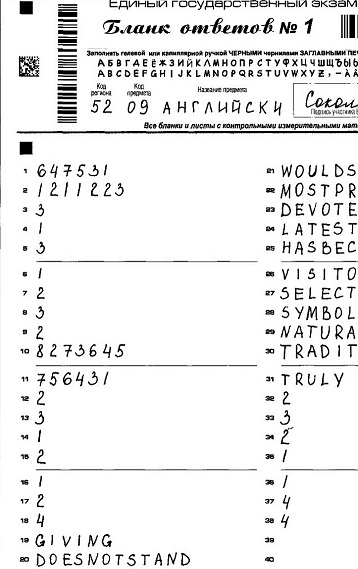

In [66]:
Image(filename='blank.jpg')

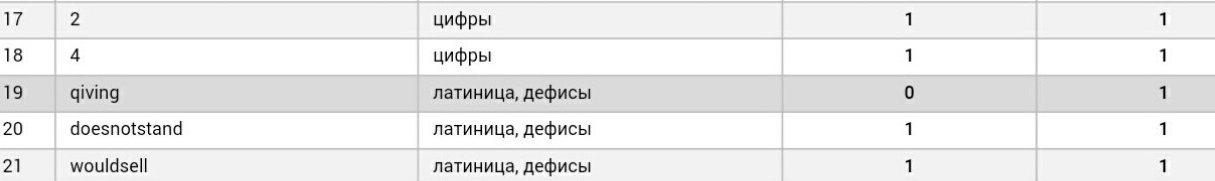

In [69]:
Image(filename='answers.jpg')

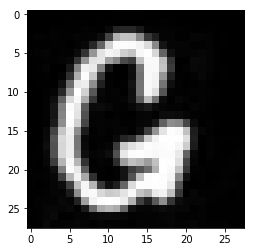

In [68]:
x_svetatest = np.zeros((1, 784))
name = 'SvetaG.png'
x = rgb2gray(plt.imread(name)).T
plt.imshow(x.T, cmap = 'gray')
plt.show()
x = x.reshape((-1, 784))
x_svetatest = x

y_svetatest = np.zeros((1, 26))
y_svetatest[0, 6] = 1

In [79]:
N, M = x_train.shape 
O = 784 
T = 26 
batch_size = 300
learning_rate = 0.0000015 
training_epochs = 5

ops.reset_default_graph()

inp = tf.placeholder(shape=(None, M), dtype=tf.float32) 
out = tf.placeholder(shape=(None, T), dtype=tf.float32)

weights_output = tf.Variable(tf.zeros([M,T])) 
bias_output = tf.Variable(tf.ones([T])/T) 
evidence=tf.matmul(inp,  weights_output)+bias_output 
output = tf.nn.softmax(evidence)

cross_entropy=tf.nn.softmax_cross_entropy_with_logits_v2(logits=evidence, labels=out)
cross_entropy=tf.reduce_mean(cross_entropy)

train_step=tf.train.RMSPropOptimizer(learning_rate).minimize(cross_entropy)

correct_prediction=tf.equal(tf.argmax(output, 1), tf.argmax(out, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

tf.summary.scalar("Cost", cross_entropy)
tf.summary.scalar("Accuracy", accuracy)
summary_op=tf.summary.merge_all()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    #writer
    for epoch in range(training_epochs):
        print('###################################################################')
        print("Epoch:", epoch + 1)
        batch_count= int(N/batch_size)
        for i in range(batch_count):
            start, finish = batch_size*i, batch_size*(i+1)
            batch_x, batch_y = x_train[start: finish, :], y_train[start: finish, :]
            d = {inp: batch_x, out: batch_y}
            _, summary=sess.run([train_step, summary_op], feed_dict=d )
        print("Accuracy: ", accuracy.eval(feed_dict={inp: x_svetatest, out: y_svetatest})) 
        print("Prediction: ", sess.run(tf.argmax(output, 1), feed_dict={inp: x_svetatest}))

###################################################################
Epoch: 1
Accuracy:  1.0
Prediction:  [6]
###################################################################
Epoch: 2
Accuracy:  1.0
Prediction:  [6]
###################################################################
Epoch: 3
Accuracy:  1.0
Prediction:  [6]
###################################################################
Epoch: 4
Accuracy:  1.0
Prediction:  [6]
###################################################################
Epoch: 5
Accuracy:  1.0
Prediction:  [6]


Как видно, наша модель с первой эпохи правильно идентифицировала букву

## 3 Цветовая карта нейронов 

Построить модели на которых можно увидеть, как детектируются буквы

Детектируем буквы A B C

### 0 СЛОЕВ

ЦВЕТА: белый - 1, черный -0

На ранних эпохах, где точность не особо большая видно, что значимым является область, описывающая контур буквы. Но в процессе дальшейшего обучения значимой областью становится почти вся центральная часть. Это очевидно, потому что модель берет по общий паттерн для предсказания букв.

###################################################################
Epoch: 1
Accuracy:  0.60215384


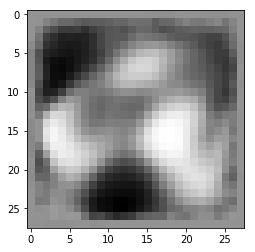

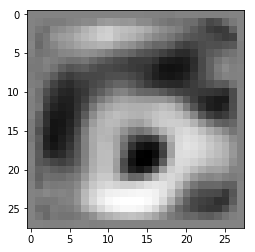

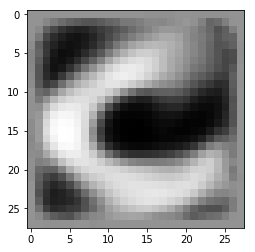

###################################################################
Epoch: 2
Accuracy:  0.64215386


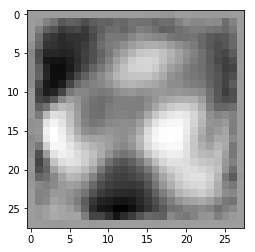

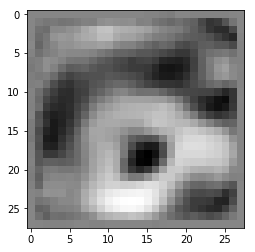

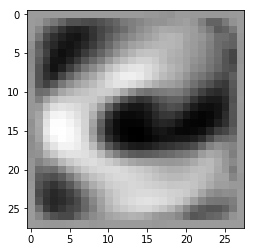

###################################################################
Epoch: 3
Accuracy:  0.6610769


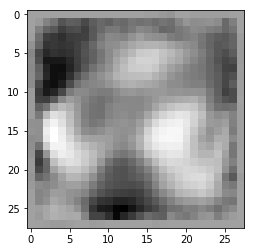

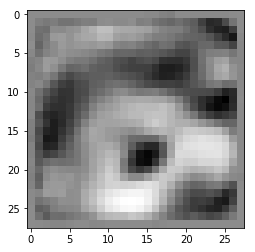

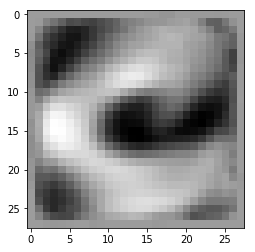

###################################################################
Epoch: 4
Accuracy:  0.6743077


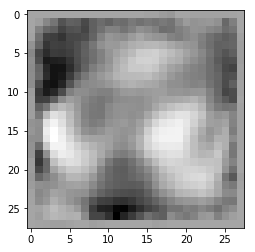

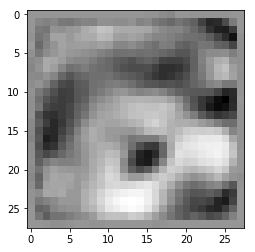

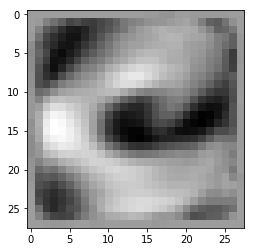

###################################################################
Epoch: 5
Accuracy:  0.6812308


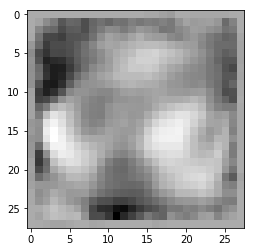

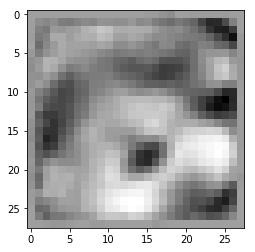

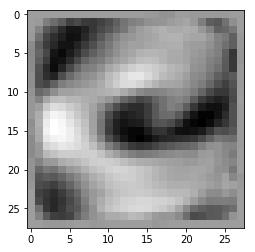

###################################################################
Epoch: 6
Accuracy:  0.68492305


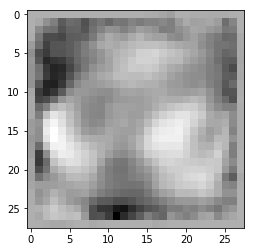

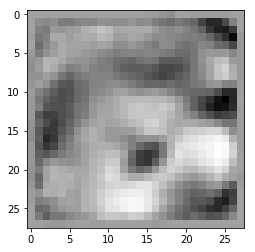

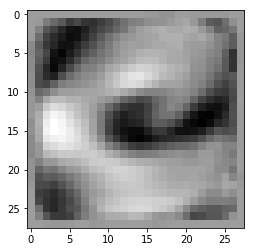

###################################################################
Epoch: 7
Accuracy:  0.6876923


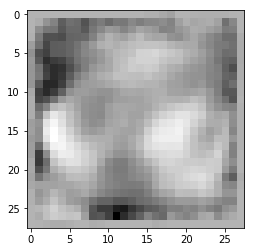

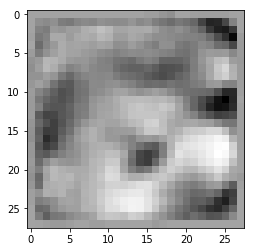

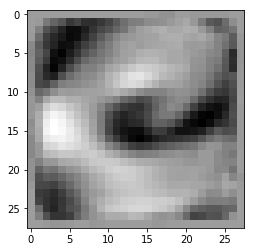

###################################################################
Epoch: 8
Accuracy:  0.6887692


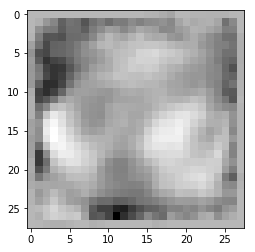

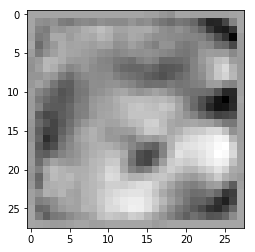

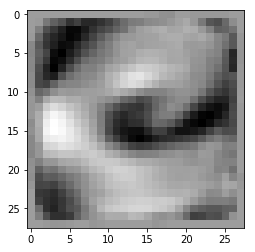

###################################################################
Epoch: 9
Accuracy:  0.6903077


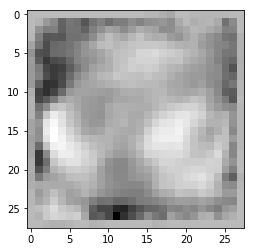

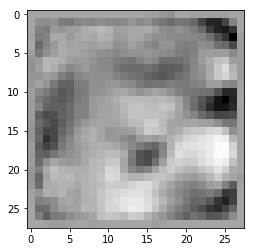

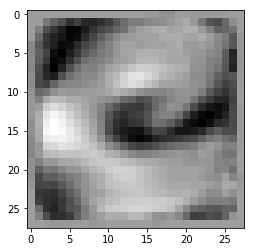

###################################################################
Epoch: 10
Accuracy:  0.6927692


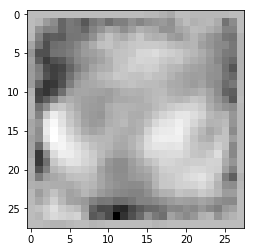

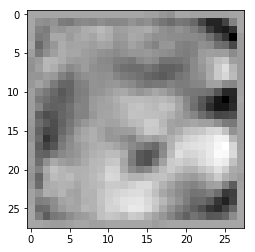

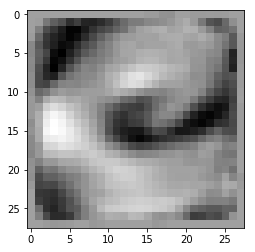

In [38]:
N, M = x_train.shape 
O = 784 
T = 26 
batch_size = 300
learning_rate = 0.0000015 
training_epochs = 10
ops.reset_default_graph()

inp = tf.placeholder(shape=(None, M), dtype=tf.float32) 
out = tf.placeholder(shape=(None, T), dtype=tf.float32)

weights_output = tf.Variable(tf.zeros([M,T]))
bias_output = tf.Variable(tf.ones([T])/T) 
evidence=tf.matmul(inp,  weights_output)+bias_output
output = tf.nn.softmax(evidence) 

cross_entropy=tf.nn.softmax_cross_entropy_with_logits_v2(logits=evidence, labels=out)
cross_entropy=tf.reduce_mean(cross_entropy)

train_step=tf.train.RMSPropOptimizer(learning_rate).minimize(cross_entropy)

correct_prediction=tf.equal(tf.argmax(output, 1), tf.argmax(out, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

tf.summary.scalar("Cost", cross_entropy)
tf.summary.scalar("Accuracy", accuracy)
summary_op=tf.summary.merge_all()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for epoch in range(training_epochs): 
        print('###################################################################')
        print("Epoch:", epoch + 1)
        batch_count= int(N/batch_size) 
        for i in range(batch_count):
            start, finish = batch_size*i, batch_size*(i+1)
            batch_x, batch_y = x_train[start: finish, :], y_train[start: finish, :]
            d = {inp: batch_x, out: batch_y}
            _, summary=sess.run([train_step, summary_op], feed_dict=d )
        print("Accuracy: ", accuracy.eval(feed_dict={inp: x_test, out: y_test})) 

        for i in range(3):
            t_map = weights_output.eval()[:, i].reshape((28, 28)).T
            plt.imshow(t_map, cmap='gray')
            plt.show()  

### 1 СЛОЙ

На модели с одним скрытым слоем можно увидеть несколько паттернов, с помощью которых производится идентификация букв.

###################################################################
Epoch: 1
Accuracy:  0.18676923


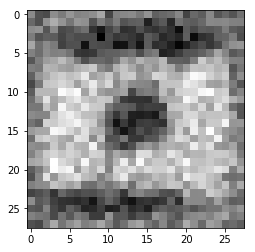

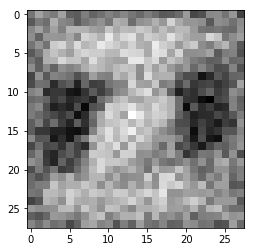

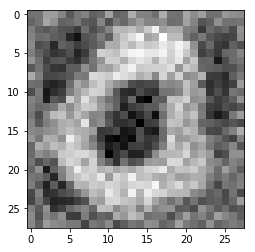

###################################################################
Epoch: 2
Accuracy:  0.2990769


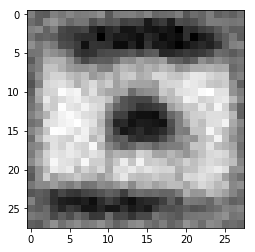

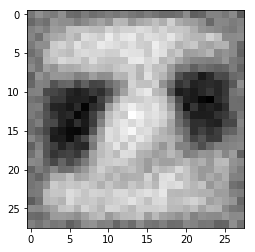

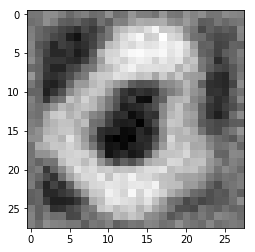

###################################################################
Epoch: 3
Accuracy:  0.39830768


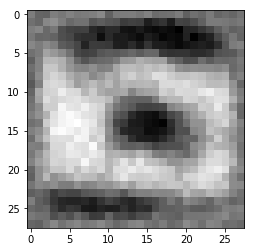

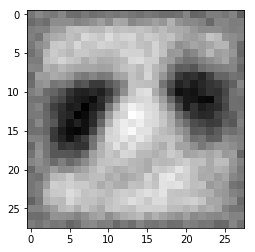

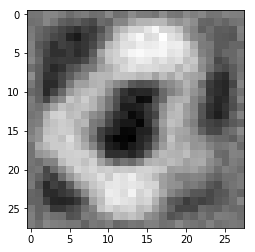

###################################################################
Epoch: 4
Accuracy:  0.46215385


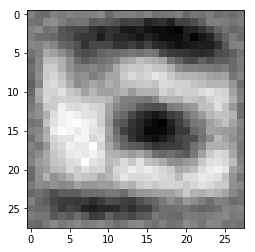

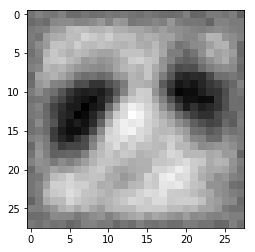

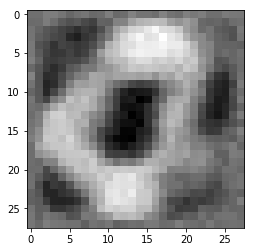

###################################################################
Epoch: 5
Accuracy:  0.49092308


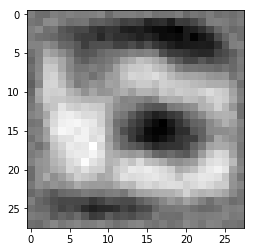

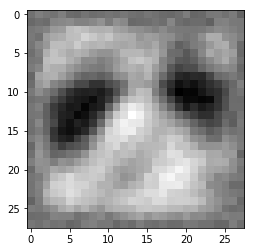

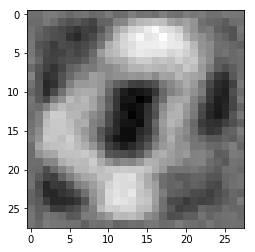

###################################################################
Epoch: 6
Accuracy:  0.5077692


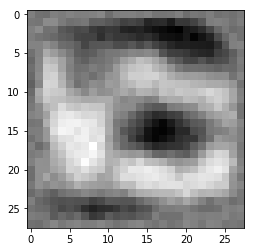

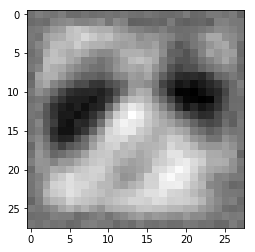

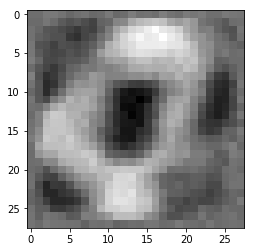

###################################################################
Epoch: 7
Accuracy:  0.52338463


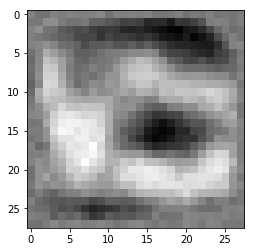

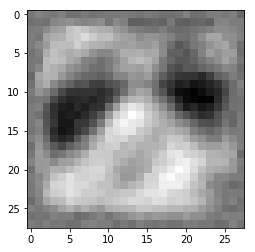

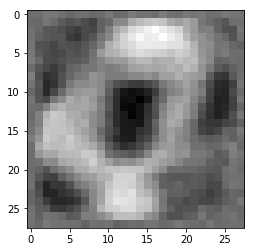

###################################################################
Epoch: 8
Accuracy:  0.5320769


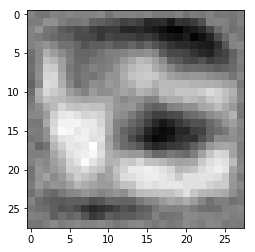

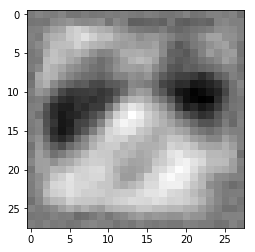

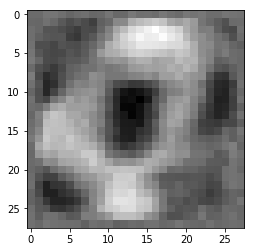

###################################################################
Epoch: 9
Accuracy:  0.53946155


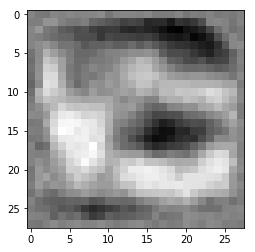

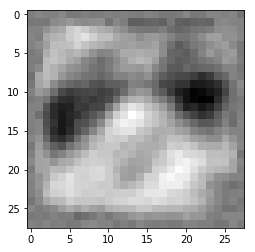

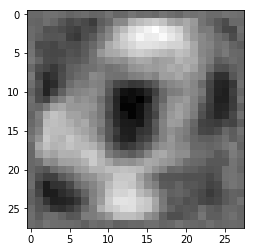

###################################################################
Epoch: 10
Accuracy:  0.546


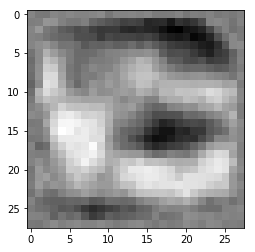

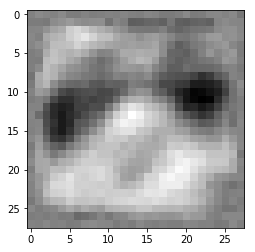

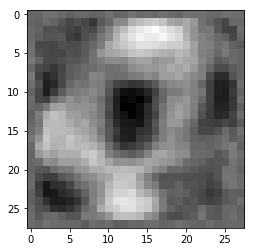

In [42]:
N, M = x_train.shape 
O = 7
T = 26 
batch_size = 300
learning_rate = 0.000025 
training_epochs = 10

ops.reset_default_graph()

inp = tf.placeholder(shape=(None, M), dtype=tf.float32) 
out = tf.placeholder(shape=(None, T), dtype=tf.float32)

weights1 = tf.Variable(tf.truncated_normal([M, O], stddev=np.sqrt(1/(M**2)))) 
bias1 = tf.Variable(tf.ones([O])/O) 
layer1 = tf.nn.relu(tf.matmul(inp, weights1) + bias1)

weights_output = tf.Variable(tf.zeros([O,T])) 
bias_output = tf.Variable(tf.ones([T])/T) 
evidence=tf.matmul(layer1,  weights_output)+bias_output 
output = tf.nn.softmax(evidence)

cross_entropy=tf.nn.softmax_cross_entropy_with_logits_v2(logits=evidence, labels=out)
cross_entropy=tf.reduce_mean(cross_entropy)

train_step=tf.train.RMSPropOptimizer(learning_rate).minimize(cross_entropy)

correct_prediction=tf.equal(tf.argmax(output, 1), tf.argmax(out, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

tf.summary.scalar("Cost", cross_entropy)
tf.summary.scalar("Accuracy", accuracy)
summary_op=tf.summary.merge_all()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for epoch in range(training_epochs):
        print('###################################################################')
        print("Epoch:", epoch + 1)
        batch_count= int(N/batch_size) 
        for i in range(batch_count):
            start, finish = batch_size*i, batch_size*(i+1)
            batch_x, batch_y = x_train[start: finish, :], y_train[start: finish, :]
            d = {inp: batch_x, out: batch_y}
            _, summary=sess.run([train_step, summary_op], feed_dict=d )
        
        print("Accuracy: ", accuracy.eval(feed_dict={inp: x_test, out: y_test})) 
        
        for i in range(3):
            t_map = weights1.eval()[:, i].reshape((28, 28)).T
            plt.imshow(t_map, cmap='gray')
            plt.show()             

## 4 Сравнение с другими алгоритмами

Random Forest работает намного быстрее, чем модель с тремя скрытыми слоями. Точность примерно та же.

### Random Forest

In [18]:
start = time.time()
clf = RandomForestClassifier(n_estimators=100, max_depth=50, random_state=0)
clf.fit(x_train, y_train_clf)
print(clf.score(x_test, y_test_clf))
end = time.time()
print('Time:', (end - start))

0.8687692307692307
Time: 113.52577233314514


## 5 Творческое задание

Написать на листке белой бумаги (маркером или ручкой) от 5 разных букв английского алфавита. Сфотографировать букву и привести её картинку к размеру 28х28 и чёрно-белой палитре цветов. Сделать предсказание буквы вашей моделью. 

1 в gimp нарисовали 5 букв

2 перевели в серый диапазон, используя заимствованную в интернете функцию rgb2gray 

3 транспонировали и привели матрицу в массив

РЕЗУЛЬТАТ: буквы идентифицируются

На модели с 3-мя слоями после первой эпохи идентифицируется с точность 100%

На модели с без скрытых слоев после 6 эпохи достигается 100% идентификация

Ошибается в начале на букве К. Путает с буквой Т. Причина: схожесть строения

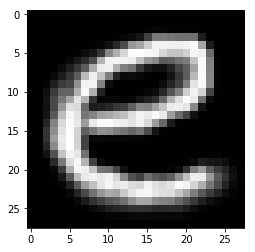

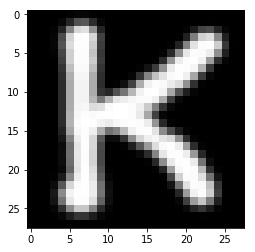

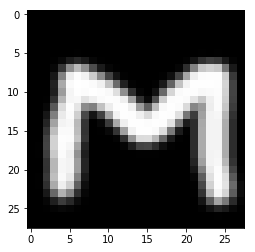

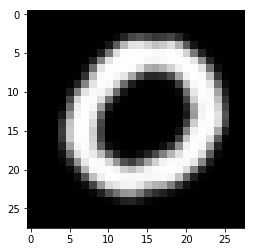

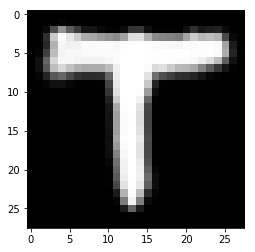

In [88]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

letters = [5, 11, 13, 15, 20] 
letter_test = [4, 10, 12, 14, 19] 
n = len(letters)
x_selftest = np.zeros((n,784))
for i in range(n):
    name = '.'.join(['letter'+ str(letters[i]), 'png'])
    x = rgb2gray(plt.imread(name)).T
    plt.imshow(x.T, cmap = 'gray')
    plt.show()
    x = x.reshape((-1, 784))
    x_selftest[i] = x
    
y_selftest = np.zeros((len(letters), 26))
for i in range(len(letters)):
    y_selftest[i, letters[i] - 1] = 1

## 3 СЛОЯ

In [30]:
N, M = x_train.shape 
O = 784 
P1 = 512 
P2 = 512
T = 26 
batch_size = 300
learning_rate = 0.0003 
training_epochs = 5

ops.reset_default_graph()

inp = tf.placeholder(shape=(None, M), dtype=tf.float32) 
out = tf.placeholder(shape=(None, T), dtype=tf.float32)

weights1 = tf.Variable(tf.truncated_normal([M, O], stddev=np.sqrt(1/M)))
bias1 = tf.Variable(tf.ones([O])/O) 
layer1 = tf.nn.relu(tf.matmul(inp, weights1) + bias1)

weights2 = tf.Variable(tf.truncated_normal([O, P1], stddev=np.sqrt(1/O)))
bias2 = tf.Variable(tf.ones([P1])/P1) 
layer2 = tf.nn.relu(tf.matmul(layer1, weights2) + bias2)

weights3 = tf.Variable(tf.truncated_normal([P1, P2], stddev=np.sqrt(1/P1)))
bias3 = tf.Variable(tf.ones([P2])/P2)
layer3 = tf.nn.relu(tf.matmul(layer2, weights3) + bias3)

weights_output = tf.Variable(tf.truncated_normal([P2,T], stddev=np.sqrt(1/P2))) 
bias_output = tf.Variable(tf.ones([T])/T) 
evidence=tf.matmul(layer3,  weights_output)+bias_output
output = tf.nn.softmax(evidence) 

cross_entropy=tf.nn.softmax_cross_entropy_with_logits_v2(logits=evidence, labels=out)
cross_entropy=tf.reduce_mean(cross_entropy)

train_step=tf.train.RMSPropOptimizer(learning_rate).minimize(cross_entropy)

correct_prediction=tf.equal(tf.argmax(output, 1), tf.argmax(out, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

tf.summary.scalar("Cost", cross_entropy)
tf.summary.scalar("Accuracy", accuracy)
summary_op=tf.summary.merge_all()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for epoch in range(training_epochs):
        print("Epoch:", epoch + 1)
        batch_count= int(N/batch_size)
        for i in range(batch_count):
            start, finish = batch_size*i, batch_size*(i+1)
            batch_x, batch_y = x_train[start: finish, :], y_train[start: finish, :]
            d = {inp: batch_x, out: batch_y}
            _, summary=sess.run([train_step, summary_op], feed_dict=d )
        print("Accuracy: ", accuracy.eval(feed_dict={inp: x_selftest, out: y_selftest}))

Epoch: 1
Accuracy:  0.8
Epoch: 2
Accuracy:  1.0
Epoch: 3
Accuracy:  1.0
Epoch: 4
Accuracy:  1.0
Epoch: 5
Accuracy:  1.0


## 0 СЛОЕВ

In [92]:
N, M = x_train.shape 
O = 784 
T = 26 
batch_size = 300
learning_rate = 0.0000015 
training_epochs = 10

ops.reset_default_graph()

inp = tf.placeholder(shape=(None, M), dtype=tf.float32) 
out = tf.placeholder(shape=(None, T), dtype=tf.float32)

weights_output = tf.Variable(tf.zeros([M,T]))
bias_output = tf.Variable(tf.ones([T])/T) 
evidence=tf.matmul(inp,  weights_output)+bias_output 
output = tf.nn.softmax(evidence) 

cross_entropy=tf.nn.softmax_cross_entropy_with_logits_v2(logits=evidence, labels=out)
cross_entropy=tf.reduce_mean(cross_entropy)

train_step=tf.train.RMSPropOptimizer(learning_rate).minimize(cross_entropy) 

correct_prediction=tf.equal(tf.argmax(output, 1), tf.argmax(out, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

tf.summary.scalar("Cost", cross_entropy)
tf.summary.scalar("Accuracy", accuracy)
summary_op=tf.summary.merge_all()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    for epoch in range(training_epochs): 
        print("Epoch:", epoch + 1)
        batch_count= int(N/batch_size)
        for i in range(batch_count):
            start, finish = batch_size*i, batch_size*(i+1)
            batch_x, batch_y = x_train[start: finish, :], y_train[start: finish, :]
            d = {inp: batch_x, out: batch_y}
            _, summary=sess.run([train_step, summary_op], feed_dict=d )
        print("Accuracy: ", accuracy.eval(feed_dict={inp: x_selftest, out: y_selftest})) 
        if(epoch == 0):
            new_y_pred= sess.run(tf.argmax(output, 1), feed_dict={inp: x_selftest})
            cm = confusion_matrix(letter_test, new_y_pred)[0:5, 0:6]
            print('Confusion matrix: ', cm)

Epoch: 1
Accuracy:  0.8
Confusion matrix:  [[1 0 0 0 0 0]
 [0 0 0 0 0 1]
 [0 0 1 0 0 0]
 [0 0 0 1 0 0]
 [0 0 0 0 1 0]]
Epoch: 2
Accuracy:  0.8
Epoch: 3
Accuracy:  0.8
Epoch: 4
Accuracy:  0.8
Epoch: 5
Accuracy:  0.8
Epoch: 6
Accuracy:  0.8
Epoch: 7
Accuracy:  1.0
Epoch: 8
Accuracy:  1.0
Epoch: 9
Accuracy:  1.0
Epoch: 10
Accuracy:  1.0


## ВЫВОД 

Построили сеть с 2-мя и 3-мя скрытыми слоями. Провели тест сравнения параметров batch size и learning rate b и точность предсказания.

Матрица смежности результатов и предсказаний. Нашли, какие буквы чаще всего путаются(достаточно очевидно). Провели эксперивент из реальной жизни ЕГЭ.

Тепловая карта весов и идентификация букв.

Сравнение с Random Forest - ОГРОМЕННЫЙ выиграш дает во времени  113.5 и 1545528997.7 

Творческое задание со своими буквами. Выяснили какие буквы путаются в начале и почему.